In [9]:
library(ggplot2)
library(data.table)
library(dplyr)
library(tidyr)
library(purrr) 
library(patchwork)
library(cowplot)
library(ggbreak)
library(scales)
if (!require(extrafont)) install.packages("extrafont")
library(extrafont)

# 3. 폰트 로드
loadfonts()

cmex10 already registered with pdfFont().

cmmi10 already registered with pdfFont().



cmr10 already registered with pdfFont().

cmsy10 already registered with pdfFont().

DejaVu Sans already registered with pdfFont().

DejaVu Sans Condensed already registered with pdfFont().

DejaVu Sans Light already registered with pdfFont().

esint10 already registered with pdfFont().

eufm10 already registered with pdfFont().

Liberation Mono already registered with pdfFont().

msam10 already registered with pdfFont().

msbm10 already registered with pdfFont().

rsfs10 already registered with pdfFont().

stmary10 already registered with pdfFont().

wasy10 already registered with pdfFont().

cmex10 already registered with postscriptFont().

cmmi10 already registered with postscriptFont().

cmr10 already registered with postscriptFont().

cmsy10 already registered with postscriptFont().

DejaVu Sans already registered with postscriptFont().

DejaVu Sans Condensed already registered with postscriptFont().

DejaVu Sans Light already registered with postscriptFont().

esint10 already reg

# Step 1. Load data

In [10]:
df_ukb <- fread(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/data/UKB/obj2/prediction-X/X.tsv",
    sep = "\t"
)

head(df_ukb)

pheno,lambda,weight,Vx,lower_Vx,upper_Vx
<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
Weight,0.5875425,-2,0.06138966,0.018048008,0.10262481
Weight,0.5875425,-1,0.05108733,0.025227708,0.09352426
Weight,0.5875425,0,0.03464890,0.011180160,0.06484540
Weight,0.5875425,1,0.02507786,0.007549218,0.04625433
Weight,0.5875425,2,0.01674065,0.003217986,0.03152318
Weight,0.5875425,3,0.01102167,0.002697115,0.02128587


In [11]:
df_gcta <- fread(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/data/other-methods/GREML/X/X.filtered.gcta",
    sep = "\t"
)

head(df_gcta)

pheno,Vx,lower_Vx,upper_Vx
<chr>,<dbl>,<dbl>,<dbl>
Urate,0.003119093,0.0009434320,0.005294753
Standing_height,0.020602558,0.0179909735,0.023214143
IGF-1,0.007575075,0.0052152325,0.009934918
Monocyte_count,0.002644991,0.0004942725,0.004795709
Platelet_count,0.002987333,0.0008503817,0.005124285
Mean_reticulocyte_volume,0.002744812,0.0005995979,0.004890026


In [12]:
df_corr <- df_ukb %>%
  filter(lower_Vx > 1e-4) %>%
  inner_join(
    df_gcta %>% filter(lower_Vx > 1e-4),
    by = "pheno",
    suffix = c("_ukb", "_gcta")
  )

df_corr %>% head(5)

pheno,lambda,weight,Vx_ukb,lower_Vx_ukb,upper_Vx_ukb,Vx_gcta,lower_Vx_gcta,upper_Vx_gcta
<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Weight,0.5875425,-2,0.06138966,0.018048008,0.10262481,0.006437197,0.004207143,0.008667251
Weight,0.5875425,-1,0.05108733,0.025227708,0.09352426,0.006437197,0.004207143,0.008667251
Weight,0.5875425,0,0.03464890,0.011180160,0.06484540,0.006437197,0.004207143,0.008667251
Weight,0.5875425,1,0.02507786,0.007549218,0.04625433,0.006437197,0.004207143,0.008667251
Weight,0.5875425,2,0.01674065,0.003217986,0.03152318,0.006437197,0.004207143,0.008667251


# plot theme

In [14]:
# 공통 테마 함수 정의
get_nature_theme <- function() {
    theme_bw() +
        theme(
            # 전체적인 배경
            panel.background = element_rect(fill = NA, color = NA),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.border = element_blank(),  
            
            # 축 설정
            axis.line.x.top = element_blank(),
            axis.line.y.right = element_blank(),
            axis.line.x.bottom = element_line(color = "black", size = 0.3),  
            axis.line.y.left = element_line(color = "black", size = 0.3),    
            axis.text = element_text(size = 6.5, color = "black"),
            axis.title = element_text(size = 7.5, color = "black"),
            axis.ticks = element_line(size = 0.3),
            axis.ticks.length = unit(0.8, "mm"),
            
            # 범례 설정
            legend.margin = margin(1, 1, 1, 1, unit = "mm"),
            # legend.spacing.y = unit(0.1, "cm"),
            
            # 여백 설정
            # plot.margin = unit(c(0.1, 0.2, 0.1, 0.1), "cm")
            plot.margin = margin(0, 0, 0, 0)
        )
}

# Step 2. Plot

In [15]:
# 결과를 저장할 데이터 프레임 초기화
results <- data.frame(
  weight = numeric(),
  correlation = numeric(),
  ci_lower = numeric(),
  ci_upper = numeric()
)

# 각 weight 값별로 상관계수와 신뢰구간 계산
unique_weights <- sort(unique(df_corr$weight))

for (weight in unique_weights) {
  subset <- df_corr %>% filter(weight == !!weight)
  
  # Pearson 상관계수 계산
  cor_result <- cor.test(subset$Vx_ukb, subset$Vx_gcta)
  corr <- cor_result$estimate
  n <- nrow(subset)
  
  # Fisher 변환을 통한 신뢰구간 계산
  z <- atanh(corr)
  se <- 1 / sqrt(n - 3)
  ci_lower <- tanh(z - 1.96 * se)
  ci_upper <- tanh(z + 1.96 * se)
  
  # 결과 저장
  results <- rbind(
    results,
    data.frame(
      weight = weight,
      correlation = corr,
      ci_lower = ci_lower,
      ci_upper = ci_upper
    )
  )
}

In [16]:
results$ci = results$ci_upper - results$ci_lower
results

,weight,correlation,ci_lower,ci_upper,ci
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
cor,-2,-0.6700535,-0.84504075,-0.36542529,0.4796155
cor1,-1,-0.4779733,-0.75407302,-0.05831149,0.6957615
cor2,0,-0.1287659,-0.49160375,0.27216774,0.7637715
cor3,1,0.4838323,0.11872503,0.73368583,0.6149608
cor4,2,0.6582520,0.31649431,0.84875943,0.5322651
cor5,3,0.6116220,0.28547731,0.81080769,0.5253304
cor6,4,0.4093898,-0.07107185,0.73565740,0.8067292
cor7,5,0.6490443,0.20490026,0.87153979,0.6666395
cor8,6,0.6390734,0.16414517,0.87347808,0.7093329


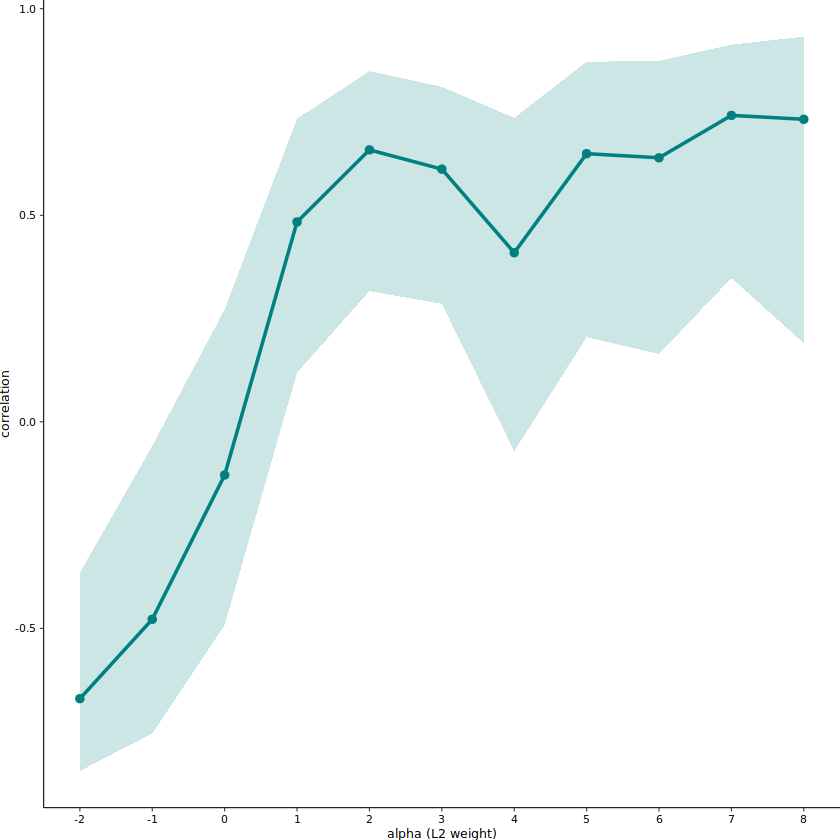

In [24]:
# 그래프 그리기
p <- ggplot(results, aes(x = weight, y = correlation)) +
  geom_ribbon(
    aes(ymin = ci_lower, ymax = ci_upper),  # fill = "CI" 제거
    alpha = 0.2, 
    fill = "#008080",  # 리본 색상을 #008080으로 설정
    color = NA
  ) +
  geom_line(color = "#008080", size = 1) +
  geom_point(color = "#008080", size = 2) +
  
  scale_x_continuous(breaks = unique(results$weight)) +
  labs(
    x = "alpha (L2 weight)",
    y = "correlation"
  ) +
  get_nature_theme()

p

In [25]:
output_path <- paste0(
    "/data/jerrylee/pjt/BIGFAM.v.2.0/figures/UKB.X.alpha-corr-with-GCTA.pdf"
)

ggsave(
    filename = output_path,
    plot = p,
    width = 81.5,
    height = 46,
    units = "mm",
    dpi = 300,
    device = cairo_pdf
)
